<a href="https://colab.research.google.com/github/architect-code/c_code/blob/main/ST463_Stochastic_Simulation%2C_Training_and_Calibration%2C_Seminar_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some general remarks about the code below:



*   As you can see, the code is readable by humans (and not just by the Python interpreter): in general, you have to choose informative function and variable names and use consistent formatting. For instance, you can check the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/) for the widely adopted coding conventions or [this guide for explanation](https://realpython.com/python-pep8/).
*   There are some **food for thought**, denoted with $\clubsuit$-$\star$, where $\star$ denote the number of the **food for thought**: you can submit these exercises to me. Their submission is voluntary, but I will be happy to provide detailed feedbacks. If you decide to submit these exercises please create a new .ipynb file named "ST463 - Lecture I - "YOUR NAME" - "YOUR SURNAME"".
* For each part of the exercise a solution box has been added, but you may insert additional boxes. Do not hesitate to add Text boxes for textual or LaTeX answers (via `+Text`). But make sure to replace any part that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove the `raise NotImplementedError()`.

# Inversion method.

Recall that knowing the cumulative distribution function fully characterizes the distribution of a random variable. The **inversion method** allows to explicitly construct such a random variable from a uniform random variable. To this end we consider the **(generalized) inverse distribution function**

$$
F_X^{-1}(p) := \inf\{ x\in\mathbb{R} : F_X(x) \geq p\}.
$$

In the case of a continuous random variable with everywhere positive probability density this is simply the inverse function of $F_X$, but it is perfectly well-defined even when $F_X$ has jumps, like in the case when $X$ is discrete. If $U$ is a uniform random variable, then we claim that $F_X^{-1}(U)$ and $X$ are identically distributed, meaning that $F_X^{-1}(U)$ has CDF $F_X$. This follows from the fact that for any $p\in [0,1]$ we have $F_X^{-1}(p) \leq x$ if and only if $p \leq F_X(x)$, which directly implies

$$
\mathbb{P}( F_X^{-1}(U) \leq x ) = \mathbb{P}( U \leq F_X(x) ) = F_X(x).
$$

**Example 1**

Consider the continuous random variable $X$ on $(0,1)$ with probability density function $f_X(x) = 2 x$. Its CDF is given by $F_X(x) = \int_0^x f_X(y) dy = x^2$. Therefore $F_X^{-1}(U)=\sqrt{U}$ and $X$ are identically distributed.

Since the uniform random variable $U$ is very simple to sample on the computer, this gives a powerful method to sample from other distributions as long as the inverse distribution function is manageable. For instance, we can verify the previous example as follows.

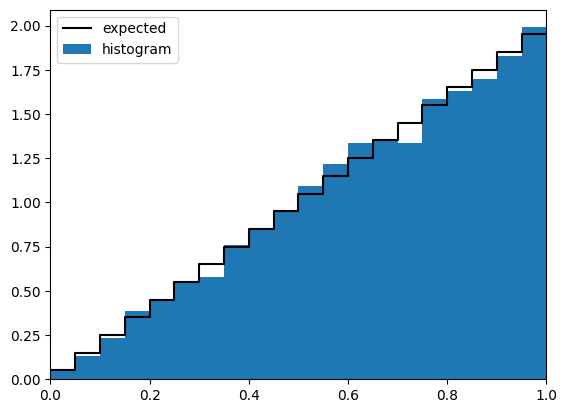

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from scipy.integrate import quad

rng = np.random.default_rng()
%matplotlib inline

def inversion_sample(f_inverse):
    '''Obtain an inversion sample based on the inverse-CDF f_inverse.'''
    return f_inverse(rng.random())

def compare_plot(samples,pdf,xmin,xmax,bins):
    '''Draw a plot comparing the histogram of the samples to the expectation coming from the pdf.'''
    xval = np.linspace(xmin,xmax,bins+1)
    binsize = (xmax-xmin)/bins
    # Calculate the expected numbers by numerical integration of the pdf over the bins
    expected = np.array([quad(pdf,xval[i],xval[i+1])[0] for i in range(bins)])/binsize
    measured = np.histogram(samples,bins,(xmin,xmax))[0]/(len(samples)*binsize)
    plt.plot(xval,np.append(expected,expected[-1]),"-k",drawstyle="steps-post")
    plt.bar((xval[:-1]+xval[1:])/2,measured,width=binsize)
    plt.xlim(xmin,xmax)
    plt.legend(["expected","histogram"])
    plt.show()

def f_inv_triangular(p):
    return np.sqrt(p)

def pdf_triangular(x):
    return 2*x

compare_plot([inversion_sample(f_inv_triangular) for _ in range(10000)],pdf_triangular,0,1,20)

**Example 2** Let now $X$ have the **Pareto distribution** of **shape** $\alpha > 0$ on $(b,\infty)$, which has  probability density function $f_X(x) = \alpha b^{\alpha} x^{-\alpha-1}$ for $x > b$. Write a function `f_inv_pareto` that computes $F_X^{-1}(p)$. Compare a histogram with a plot of $f_X(x)$ to verify your function numerically.

**Solution** The CDF is $F_X(x) = \int_{b}^x \alpha b^{\alpha}x^{-\alpha-1} = b^{\alpha}(b^{-\alpha} - x^{-\alpha})=1-(b/x)^{\alpha}$, so $F_X^{-1}(p) = b(1-p)^{-1/\alpha}$.

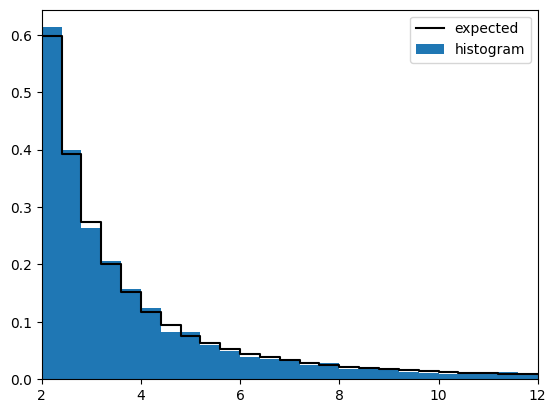

In [ ]:
### Solution
def f_inv_pareto(alpha,b,p):
    return b / (1-p)**(1/alpha)

# plotting
alpha = 1.5
b = 2.0
compare_plot([inversion_sample(lambda p:f_inv_pareto(alpha,b,p)) for _ in range(5000)],
             lambda x:alpha*(b**alpha)*(x**(-alpha-1)),
             2,12,25)

**Exemple 3** Let $X$ be a discrete random variable taking values in $\{1,2,\ldots,n\}$. Write a Python function `f_inv_discrete` that takes the probability mass function $p_X$ as a list `prob_list` given by $[p_X(1),\ldots,p_X(n)]$ and returns a random sample with the distribution of $X$ using the inversion method. Verify the working of your function numerically on an example.

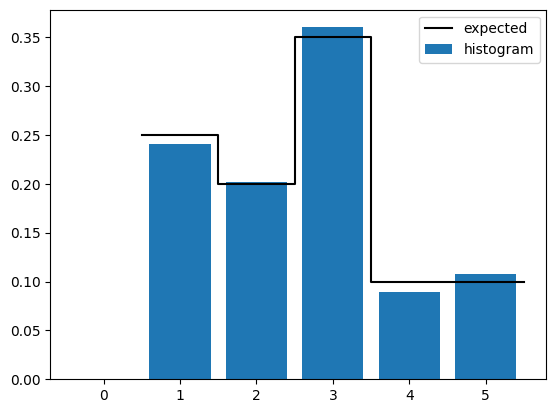

In [ ]:
def f_inv_discrete(prob_list,p):
    ### BEGIN SOLUTION
    # need to find first x such that the CDF F(x) >= p
    cdf = 0.0
    for x, prob in enumerate(prob_list):
        cdf += prob
        if( cdf >= p ):
            return x+1 # note the index starts at 0 instead of 1
    ### END SOLUTION

# plotting
### BEGIN SOLUTION
trials = 1000
p_list = [0.25,0.2,0.35,0.1,0.1]
samples = np.array([inversion_sample(lambda p : f_inv_discrete(p_list,p)) for _ in range(trials)])
measured = np.bincount(samples)/trials
plt.plot(np.arange(0.5,len(p_list)+1.5),np.append(p_list,p_list[-1]),"-k",drawstyle="steps-post")
plt.bar(np.arange(0,len(measured)),measured)
plt.legend(["expected","histogram"])
plt.show()
### END SOLUTION

# Central Limit Theorem?

In this exercise we will have a closer look at central limits of the Pareto distribution, for which you implemented a random sampler in the previous exercise. By performing the appropriate integrals it is straightforward to show that

$$
\mathbb{E}[X] = \begin{cases} \infty & \text{for }\alpha \leq 1 \\ \frac{\alpha b}{\alpha - 1} & \text{for }\alpha > 1 \end{cases}, \qquad \operatorname{Var}(X) = \begin{cases} \infty & \text{for }\alpha \leq 2 \\ \frac{\alpha b^2}{(\alpha - 1)^2(\alpha-2)} & \text{for }\alpha > 2 \end{cases}.
$$

This shows in particular that the distribution is **heavy tailed**, in the sense that some moments $\mathbb{E}[X^k]$ diverge.

1. Write a function `sample_Zn` that produces a random sample for $Z_n= \frac{\sqrt{n}}{\sigma_X}(\bar{X}_n - \mathbb{E}[X])$ given $\alpha>2$, $b>0$ and $n\geq 1$. Visually verify the central limit theorem for $\alpha = 4$, $b=1$ and $n=1000$ by comparing a histogram of $Z_n$ to the standard normal distribution (you may use `compare_plot`).

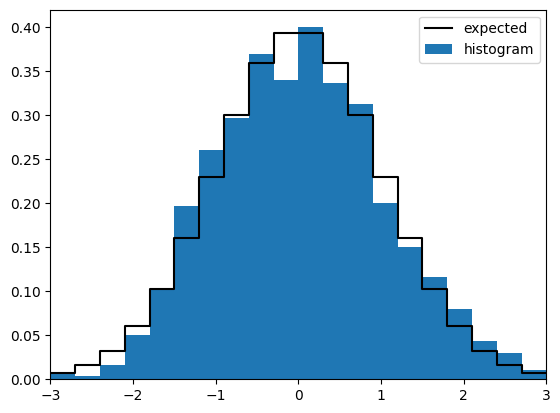

In [ ]:
def sample_Zn(alpha,b,n):
    X=np.array([inversion_sample(lambda p:f_inv_pareto(alpha,b,p)) for _ in range(n)])
    var = alpha * b**2 / ((alpha-1)**2*(alpha-2))
    mean = alpha * b / (alpha-1)
    return np.sqrt(n/var)*(np.mean(X)-mean)
def gaussian(x):
    return np.exp(-x*x/2)/np.sqrt(2*np.pi)

# Plotting
reps=1000
n=1000
alpha=4
b=1
Z=np.array([sample_Zn(alpha,b,n) for _ in range(reps)])

compare_plot(Z,gaussian,-3.0,3.0,20)

# Joint probability density functions and sampling the normal distribution.

Let $\Phi$ be a uniform random variable on $(0,2\pi)$ and $R$ an independent continuous random variable with probability density function $f_R(r) = r\,e^{-r^2/2}$ for $r>0$. Set $X = R \cos \Phi$ and $Y = R \sin \Phi$. This is called the **Box-Muller transform**.

1.   Since $\Phi$ and $R$ are independent, the joint probability density of $\Phi$ and $R$ is $f_{\Phi,R}(\phi,r) = f_\Phi(\phi)f_R(r) = \frac{1}{2\pi}\, r\,e^{-r^2/2}$. Show by change of variables that $X$ and $Y$ are also independent and both distributed as a standard normal distribution $\mathcal{N}$.

**Solution**
It is a transformation from polar to Cartesian coordinates, for which we recall that $r dr d\phi = dx dy$. This gives:
\begin{equation}
f_{\Phi,R}(\phi,r)dr\,d\phi = \frac{1}{2\pi} r e^{-r^2/2} dr\,d\phi = \frac{1}{2 \pi}e^{-(x^2+y^2)/2}dx\,dy = f_{X,Y}(x,y) dx\,dy.
\end{equation}
Since the joint probability density function is factorized, $X$ and $Y$ are independent and each have density $\frac{1}{\sqrt{2 \pi}}e^{-x^2/2} = f_{\mathcal{N}(x)}$.

2.   Write a function to sample a pair of independent normal random variables using the Box-Muller transform. Hint: to sample $R$ you can use the inversion method. Produce a histogram to check the distribution of your normal variables.

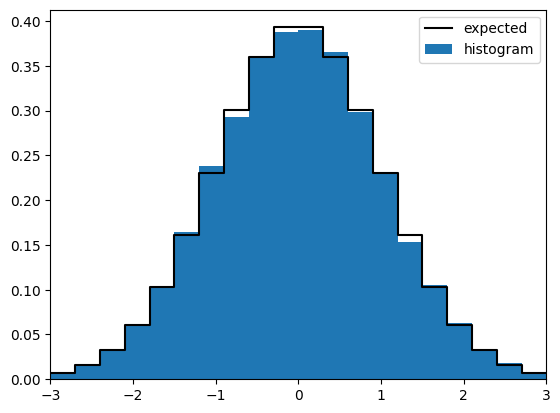

In [ ]:
def random_normal_pair():
    '''Return two independent normal random variables.'''
    ### BEGIN SOLUTION
    # the CDF of R is 1 - e^{-r^2/2}, so inverse \sqrt{-2\log(1-u)}
    r = np.sqrt(-2 * np.log(rng.random()))
    phi = rng.uniform(0,2*np.pi)
    x=r*np.cos(phi)
    y=r*np.sin(phi)
    ### END SOLUTION
    return x, y

def gaussian(x):
    return np.exp(-x*x/2)/np.sqrt(2*np.pi)

# Plotting
### BEGIN SOLUTION
samples = np.array([random_normal_pair() for _ in range(10000)]).flatten()
compare_plot(samples,gaussian,-3.0,3.0,20)
### END SOLUTION